# ResNet
Fashion-MNIST Image Classification using ResNet-18

## 1. Setup

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
#Hyper-parameters
batch_size  = 128
num_classes = 10 #Fashion-MNIST

In [41]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.1307, ))
])

train = datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transform)
test  = datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transform)
#Dataloader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader  = DataLoader(test, batch_size = batch_size, shuffle = False)

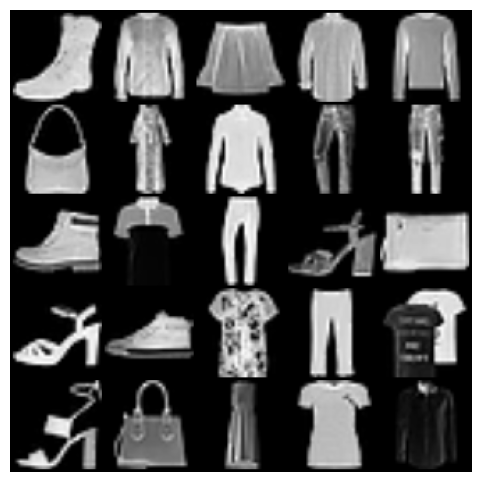

In [42]:
data_iter = iter(train_loader)
real_images, _ = next(data_iter)
grid_img = make_grid(real_images[:25], nrow = 5, normalize = True)
plt.figure(figsize = (6,6))
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

## 2. ResNet18

In [48]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride = 1, downsample = None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace = True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2   = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out  = self.relu(out)
        
        return out

In [53]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        #Input
        self.inplanes = 64
        #First Convolution layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace = True)
        #Pooling
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        #RESNET
        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    
    def _make_layer(self, block, planes, num_blocks, stride = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample)
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)       #Lớp tích chập đầu tiên
        x = self.bn1(x)         #Chuẩn hóa Batch
        x = self.relu(x)        #ReLU
        x = self.maxpool(x)     #Gộp cực đại
        
        x = self.layer1(x)      #Lớp ResNet 1
        x = self.layer2(x)      #Lớp ResNet 2
        x = self.layer3(x)      #Lớp ResNet 3
        x = self.layer4(x)      #Lớp ResNet 4
		
        x = self.avgpool(x)     #Gộp trung bình toàn cục
        x = torch.flatten(x, 1) #Flatten đặc trưng
        x = self.fc(x)          #Lớp kết nối đầy đủ
		
        return x

In [54]:
def resnet18(num_classes, **kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, **kwargs)

net = resnet18(num_classes=10)
net

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3. Training

In [55]:
learning_rate = 0.01
num_epochs    = 10
criterion     = nn.CrossEntropyLoss()
optimizer     = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)

net = net.to(device)

In [56]:
for epoch in range(num_epochs):
    #Train
    net.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    #Evaluation
    net.eval()
    test_loss = 0.0
    test_correct_predictions = 0
    test_total_samples = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total_samples += labels.size(0)
            test_correct_predictions += (predicted == labels).sum().item()

    test_epoch_loss = test_loss / len(test_loader)
    test_epoch_accuracy = test_correct_predictions / test_total_samples
    print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.4f}")

Epoch [1/10], Loss: 0.3665, Accuracy: 0.8654
Test Loss: 0.2848, Test Accuracy: 0.8944
Epoch [2/10], Loss: 0.2303, Accuracy: 0.9151
Test Loss: 0.3287, Test Accuracy: 0.8803
Epoch [3/10], Loss: 0.1845, Accuracy: 0.9320
Test Loss: 0.2390, Test Accuracy: 0.9132
Epoch [4/10], Loss: 0.1558, Accuracy: 0.9413
Test Loss: 0.2290, Test Accuracy: 0.9198
Epoch [5/10], Loss: 0.1284, Accuracy: 0.9520
Test Loss: 0.2831, Test Accuracy: 0.9049
Epoch [6/10], Loss: 0.1042, Accuracy: 0.9608
Test Loss: 0.2241, Test Accuracy: 0.9267
Epoch [7/10], Loss: 0.0880, Accuracy: 0.9666
Test Loss: 0.2903, Test Accuracy: 0.9106
Epoch [8/10], Loss: 0.0739, Accuracy: 0.9729
Test Loss: 0.2401, Test Accuracy: 0.9262
Epoch [9/10], Loss: 0.0557, Accuracy: 0.9795
Test Loss: 0.2554, Test Accuracy: 0.9249
Epoch [10/10], Loss: 0.0494, Accuracy: 0.9813
Test Loss: 0.2955, Test Accuracy: 0.9262


****